# **Computer Vision** | MSc in Data Science and Engineering
## Assignment 2 - CAPTCHA Decoding
### Bruno Silva (up201508756) **|** João Carvalho (up201507023)
##### November, 2024


## TO DO

Report metrics on image level and on character level \
Report efficiency metrics like run time, number of parameters, number of FLOPs \
Do error analysis:
- identify the worst performing characters, try to improve on that front
- report common patterns like characters that are visibly difficult to identify, characters easily confusing like 0 and O, l and 1, etc. And maybe augment data on these to try to improve the model

Start from a very simple model as a baseline \
Try to get class representation percentages to see if there is any class imbalance \
Consider using grayscale images - maybe first with normal images and then grayscale to see if there's any difference in performance.

Treino:
- Separar todas as imagens em caracteres diferentes e guardar com a respetiva label (temos de ter a ordem porque os caracteres estão por ordem no nome). Basicamente criar um dataset novo. Treinar o modelo nestes caracteres individuais.

Teste:
- A pipeline vai começar por dividir a imagem em caracteres e guarda a ordem. Depois caracter a caracter aplica o modelo para saber que caracter se trata.
- O output são as predictions de cada caracter por ordem.

## Introduction


In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms.functional as func
import torch.optim as optim
import os
import cv2 as cv

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cpu device


## Pre-processing (DO NOT RUN)
This is for the initial segmentation of each image into individual characters. In colab this is very slow and unreliable to run (it doesn't manage the upload of 20000+ images well). We also tried using Google Drive as the source of the data but PyTorch's DataLoader is extremely slow on fetching the data from the drive. Our solution was to run the segmentation locally and save everything in a zip file with the character images instead. The unzipping of the zip files is done below and works well with colab.

In [9]:
def segment_char(img_name, data_folder):

    img_path = os.path.join(data_folder, img_name)

    # image to grayscale
    image = cv.imread(img_path)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # grabbing contours
    _, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # applying a threshold to remove small contours
    threshold = 100
    contours = [contour for contour in contours if cv.contourArea(contour) > threshold]

    # creating individual images based on the bounding boxes
    individual_images = []
    x_values = []
    for contour in contours:
        x, y, w, h = cv.boundingRect(contour)
        x_values.append(x)
        individual_image = image[y:y+h, x:x+w]
        individual_images.append(individual_image)

    # get the sorted idx of x_values -> this is to order the images from left to right, otherwise the contours are ordered in some other way
    sorted_idx = np.argsort(x_values)
    # sort individual_images based on sorted_idx
    individual_images = [individual_images[i] for i in sorted_idx]

    # new folder for individual images
    new_data_folder = data_folder + "_ind"

    # save individual images
    full_img_name = img_name.split('.')[0]
    for i, img in enumerate(individual_images):
        char = img_name[i]
        cv.imwrite(f'{new_data_folder}/{char}_{full_img_name}_{i}.png', img)

In [10]:
data_folder = "CAPTCHA_dataset/soft/"

for folder in ['train', 'test']:
    iter_data_folder = data_folder + folder

    for img in os.listdir(iter_data_folder):
        segment_char(img, iter_data_folder)

In [11]:
# morphological operations

def dilate(array, kernel_size):
    if np.max(array) == 1:
        array2 = (array * 255).astype(np.uint8)
    else:
        array2 = array.astype(np.uint8)

    kernel = np.ones((kernel_size, kernel_size), np.uint8) 
    array_dilated = cv.dilate(array2, kernel, iterations=1) #dilate
    return array_dilated

def erode(array, kernel_size):
    if np.max(array) == 1:
        array2 = (array * 255).astype(np.uint8)
    else:
        array2 = array.astype(np.uint8)

    kernel = np.ones((kernel_size, kernel_size), np.uint8) 
    array_eroded = cv.erode(array2, kernel, iterations=1) #erode
    return array_eroded

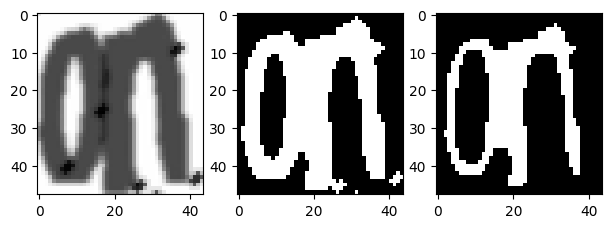

In [12]:
img_path = "CAPTCHA_dataset/soft/train_ind/s_vs0n_1.png"
img = cv.imread(img_path)
imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

_, imgThreshold = cv.threshold(img, 150, 255, cv.THRESH_BINARY_INV)

img_eroded = erode(imgThreshold, 3)

plt.figure(figsize=(15,15))
plt.subplot(1,6,1)
plt.imshow(img, cmap='gray')
plt.subplot(1,6,2)
plt.imshow(imgThreshold, cmap='gray')
plt.subplot(1,6,3)
plt.imshow(img_eroded, cmap='gray')

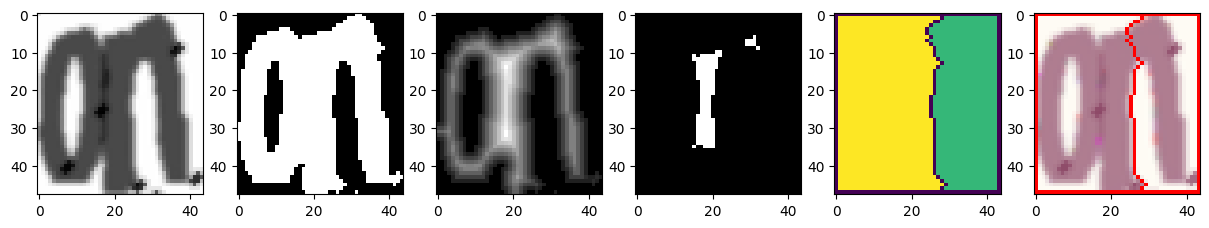

In [13]:
# WATERSHED ATTEMPT

img_path = "CAPTCHA_dataset/soft/train_ind/s_vs0n_1.png"
img = cv.imread(img_path)
imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

_, imgThreshold = cv.threshold(img, 200, 255, cv.THRESH_BINARY_INV)

distTrans = cv.distanceTransform(imgThreshold, cv.DIST_L2, 5) 

_, distThresh = cv.threshold(distTrans, 5, 255, cv.THRESH_BINARY)

distThresh = np.uint8(distThresh)
_, labels = cv.connectedComponents(distThresh)

labels = np.int32(labels)
mask = cv.watershed(imgRGB, labels)

imgRGB[mask == -1] = [255, 0, 0]


plt.figure(figsize=(15,15))
plt.subplot(1,6,1)
plt.imshow(img, cmap='gray')
plt.subplot(1,6,2)
plt.imshow(imgThreshold, cmap='gray')
plt.subplot(1,6,3)
plt.imshow(distTrans, cmap='gray')
plt.subplot(1,6,4)
plt.imshow(distThresh, cmap='gray')
plt.subplot(1,6,5)
plt.imshow(mask)
plt.subplot(1,6,6)
plt.imshow(imgRGB)

## Data

In [ ]:
# Unzipping the datasets
'''
This will unzip train_ind.zip and test_ind.zip both from the hard folder and soft folder.
Make sure to have a CAPTCHA_dataset folder with a /hard and /soft folders inside in the colab directory created before running this cell.
'''
from zipfile import ZipFile

for folder in ["train", "test"]:

    with ZipFile(f"{folder}_ind.zip", 'r') as zObject:

        zObject.extractall(path="CAPTCHA_dataset/soft/")

In [2]:
# to check if all the images are there
print(len([name for name in os.listdir('CAPTCHA_dataset/soft/train_ind')])) # should be 27662
print(len([name for name in os.listdir('CAPTCHA_dataset/soft/test_ind')])) # should be 6245

27662
6245


In [3]:
class CaptchaDataset(Dataset):
    def __init__(self, root_dir, transform):

        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # getting all image paths and labels
        for img_name in os.listdir(root_dir):
            img_path = os.path.join(root_dir, img_name)

            self.image_paths.append(img_path)

            label = img_name[0] # removing the .png from the name and choosing the first character
            self.labels.append(label)

    def __len__(self):
        return len(self.image_paths) # to get the len(dataset)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        label = torch.tensor(char_map[label], dtype=torch.long) # with this we don't need the collate function we had initially
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        return image, label

In [4]:
char_map = {ch: idx for idx, ch in enumerate("0123456789abcdefghijklmnopqrstuvwxyz")}
idx_to_char = {idx: ch for ch, idx in char_map.items()}  # Reverse mapping

char_map

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'a': 10,
 'b': 11,
 'c': 12,
 'd': 13,
 'e': 14,
 'f': 15,
 'g': 16,
 'h': 17,
 'i': 18,
 'j': 19,
 'k': 20,
 'l': 21,
 'm': 22,
 'n': 23,
 'o': 24,
 'p': 25,
 'q': 26,
 'r': 27,
 's': 28,
 't': 29,
 'u': 30,
 'v': 31,
 'w': 32,
 'x': 33,
 'y': 34,
 'z': 35}

In [5]:
transform = transforms.Compose([
    transforms.Resize((32, 16)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
train_dir = 'CAPTCHA_dataset/soft/train_ind'
test_dir = 'CAPTCHA_dataset/soft/test_ind'

train_dataset = CaptchaDataset(root_dir=train_dir, transform=transform)
test_dataset = CaptchaDataset(root_dir=test_dir, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [7]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

22129
5533
6245


Image Batch Shape: torch.Size([32, 3, 32, 16])


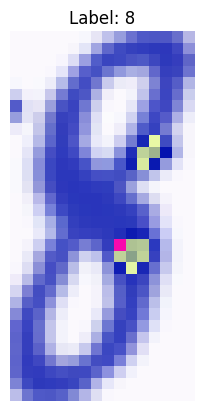

In [8]:
for images, labels in train_loader:
    print("Image Batch Shape:", images.shape)

    # first image in the batch
    first_image = images[0]
    label = labels[0]

    #converting label indices back to characters
    decoded_label = idx_to_char[label.item()]

    # this is for matplotlib to display
    first_image = func.to_pil_image(first_image)

    plt.imshow(first_image)
    plt.title(f"Label: {decoded_label}")
    plt.axis('off')
    plt.show()

    break

## Model

In [9]:
# Baseline Model

class Baseline_CNN(nn.Module):
    def __init__(self, num_classes=36):
        super(Baseline_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 4 * 8, 64) # 32x16 after two MaxPooling layers => 8x4
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
# Model Architecture

class CAPTCHA_CNN(nn.Module):
    def __init__(self, num_classes=36):
        super(CAPTCHA_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4 * 8, 256) # 32x16 after two MaxPooling layers => 8x4
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
num_classes = 36
learning_rate = 0.0001
epochs = 10

model = Baseline_CNN(num_classes=num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(train_loader, val_loader):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # train accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                # validation accuracy
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val

        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        
def eval(test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

In [17]:
train(train_loader, val_loader)

Epoch [1/10], Train Loss: 2.8804, Train Accuracy: 32.62%, Validation Loss: 1.8570, Validation Accuracy: 56.21%
Epoch [2/10], Train Loss: 1.3910, Train Accuracy: 68.01%, Validation Loss: 1.1821, Validation Accuracy: 75.08%
Epoch [3/10], Train Loss: 1.0695, Train Accuracy: 76.26%, Validation Loss: 1.0358, Validation Accuracy: 77.82%
Epoch [4/10], Train Loss: 0.9670, Train Accuracy: 79.34%, Validation Loss: 0.9734, Validation Accuracy: 79.38%
Epoch [5/10], Train Loss: 0.9067, Train Accuracy: 80.99%, Validation Loss: 0.9241, Validation Accuracy: 81.02%
Epoch [6/10], Train Loss: 0.8619, Train Accuracy: 82.27%, Validation Loss: 0.8883, Validation Accuracy: 82.02%
Epoch [7/10], Train Loss: 0.8245, Train Accuracy: 83.29%, Validation Loss: 0.8542, Validation Accuracy: 83.43%
Epoch [8/10], Train Loss: 0.7986, Train Accuracy: 83.93%, Validation Loss: 0.8300, Validation Accuracy: 83.66%
Epoch [9/10], Train Loss: 0.7708, Train Accuracy: 84.68%, Validation Loss: 0.8212, Validation Accuracy: 83.93%
E

In [18]:
eval(train_loader)
eval(val_loader)
eval(test_loader)

Test Accuracy: 85.51%
Test Accuracy: 84.67%
Test Accuracy: 84.90%


In [117]:
def classify_random_example(test_loader):
    model.eval()

    # choosing a random batch 
    data_list = list(test_loader)
    random_batch = np.random.randint(0, len(data_list))
    inputs, labels = data_list[random_batch]
    
    # random sample from the batch
    idx = np.random.randint(0, inputs.size(0))
    image, label = inputs[idx], labels[idx]

    image = image.to(device)
    label = label.to(device)

    with torch.no_grad():
        output = model(image.unsqueeze(0))
        _, predicted = torch.max(output, 1)

    image = image.cpu().permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.title(f"Predicted: {predicted.item()}, Correct: {label.item()}")
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1372549..0.9843137].


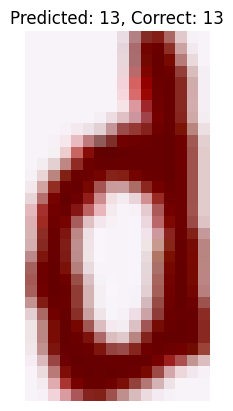

In [118]:
classify_random_example(test_loader)